In [1]:
import torch, os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import albumentations as A
from glob import glob
from tqdm import tqdm
from PIL import Image

In [2]:
class Segmentations(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.im_path_jpg = sorted(glob(f"{root}/images/*.png"))
        self.im_mask_png = sorted(glob(f"{root}/labels/*.png"))

        self.total_ims = len(self.im_path_jpg)
        self.total_gts = len(self.im_mask_png)

        assert self.total_ims == self.total_gts
        print(f'There are {self.total_ims} images and {self.total_gts} masks in the dataset')

    def __len__(self):
        return len(self.im_path_jpg)

    def __getitem__(self, idx):
        im = np.array(Image.open(self.im_path_jpg[idx]).convert('RGB'))
        gt = np.array(Image.open(self.im_mask_png[idx]))

        if self.transformations is not None:
            transformed = self.transformations(image=im, mask=gt)
            im, gt = transformed['image'], transformed['mask']

        return self.tensorize(im), torch.tensor(gt > 128).long()


def get_transformation(size):
    tfs = A.Compose([A.Resize(size, size)])
    return tfs

tfs = get_transformation(256)
ds = Segmentations(root='/kaggle/input/cardiac-semantic-segmentation-dataset/cardiac/', transformations=tfs)
print(type(ds[0][0]))
print(ds[0][1].shape)

There are 1717 images and 1717 masks in the dataset
<class 'torch.Tensor'>
torch.Size([256, 256])


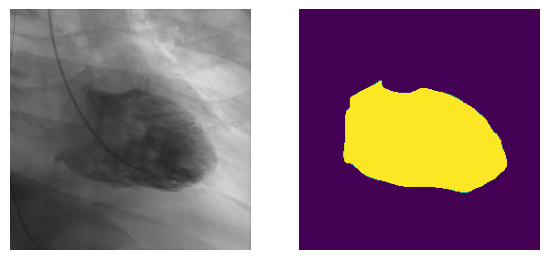

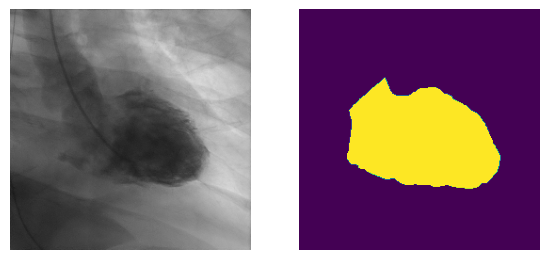

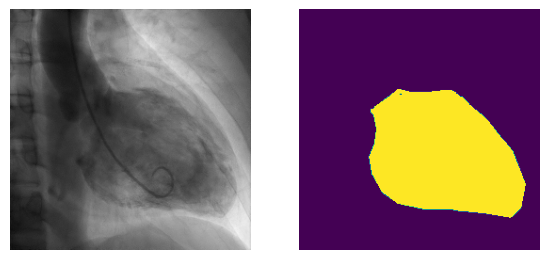

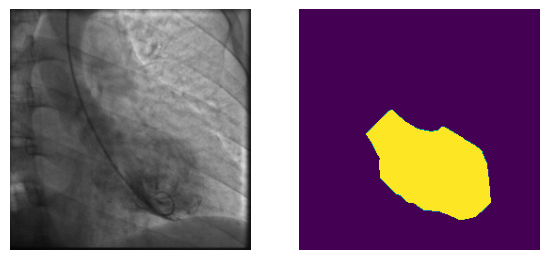

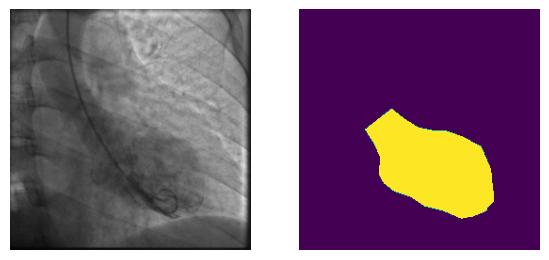

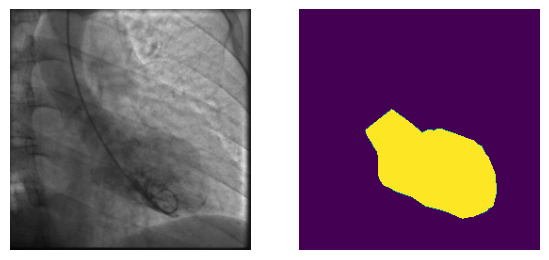

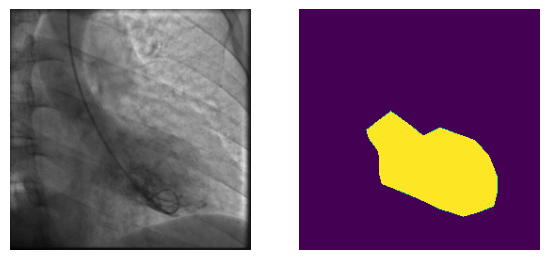

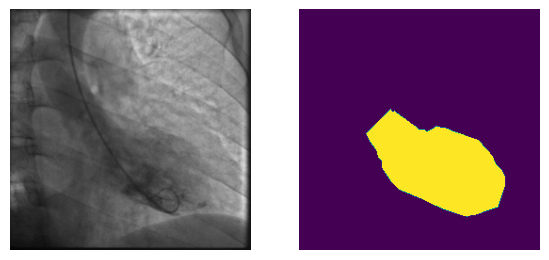

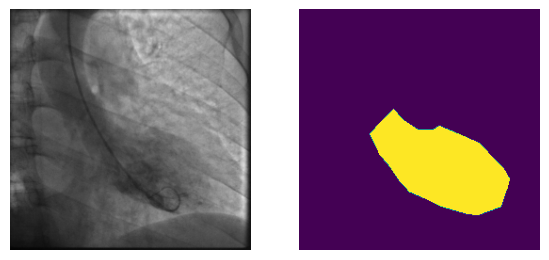

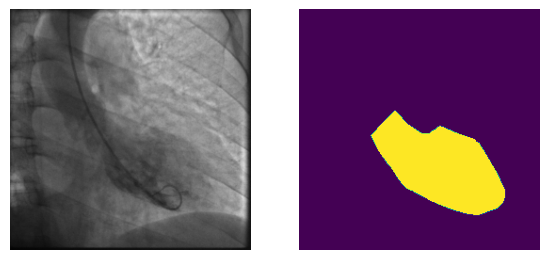

<Figure size 1800x1800 with 0 Axes>

In [3]:
def showing(ds, img_num=10, row=2):
    for idx, (im, gt) in enumerate(ds):
        count = 1
        plt.figure(figsize=(18,18))
        if idx == 10: break
        im = (im * 255).detach().cpu().permute(1,2,0).numpy().astype('uint8')# integer 8
        gt = (gt * 255).detach().cpu().numpy().astype('uint8')
        plt.subplot(row, img_num // row, count)
        plt.imshow(im)
        plt.axis('off')
        count += 1
        plt.subplot(row, img_num // row, count)
        plt.imshow(gt)
        plt.axis('off')
        count += 1
        plt.show()
        
showing(ds, 10, 2) 

In [4]:
def get_dl(root, transformations, bs, split = [0.7, 0.15, 0.15]):
    
    assert sum(split) == 1
    # Get dataset
    ds = Segmentations(root = '/kaggle/input/cardiac-semantic-segmentation-dataset/cardiac/', transformations = tfs)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    
    print(f"There are {len(tr_ds)} images in the trainset")
    print(f"There are {len(val_ds)} images in the validation set")
    print(f"There are {len(test_ds)} images in the test set")
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False)
    test_dl = DataLoader(dataset = test_ds, batch_size = bs, shuffle = False)
    
    return tr_dl, val_dl, test_dl 
    
tr_dl, val_dl, test_dl = get_dl(root = "data", bs = 16, transformations = tfs) 
print()
print(f"There are {len(tr_dl)} images in the trainloader")
print(f"There are {len(val_dl)} images in the Val_loader")
print(f"There are {len(test_dl)} images in the Test_loader")


There are 1717 images and 1717 masks in the dataset
There are 1201 images in the trainset
There are 257 images in the validation set
There are 259 images in the test set

There are 76 images in the trainloader
There are 17 images in the Val_loader
There are 17 images in the Test_loader


# Unet Architecture

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    #Forward
    def forward(self, inp):
        return self.conv_op(inp)
    
    
# Downsample class
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, inp):
        down = self.conv(inp)
        p = self.pool(down)
        
        return down, p
    
# Upsampling class
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, inp1, inp2):
        inp1 = self.up(inp1)
        x = torch.cat([inp1, inp2], dim=1)
        return self.conv(x)
    

# Building a model

In [6]:
class Unet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_conv_1 = Downsample(in_channels, 64)
        self.down_conv_2 = Downsample(64, 128)
        self.down_conv_3 = Downsample(128,256)
        self.down_conv_4 = Downsample(256,512)
        
        self.bottle_neck = DoubleConv(512,1024)
        
        self.up_conv_1 = Upsample(1024,512)
        self.up_conv_2 = Upsample(512,256)
        self.up_conv_3 = Upsample(256,128)
        self.up_conv_4 = Upsample(128,64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
        
        #Forward
    def forward(self, inp):
        down_1, p1 = self.down_conv_1(inp)
        down_2, p2 = self.down_conv_2(p1)
        down_3, p3 = self.down_conv_3(p2)
        down_4, p4 = self.down_conv_4(p3)
        
        #Bottle_neck
        b = self.bottle_neck(p4)
        
        #upsampling
        up_1 = self.up_conv_1(b, down_4)
        up_2 = self.up_conv_2(up_1, down_3)
        up_3 = self.up_conv_3(up_2, down_2)
        up_4 = self.up_conv_4(up_3, down_1)
        
        out = self.out(up_4)
        return out

In [7]:
double_conv = DoubleConv(256, 256)
print(double_conv)
inp = torch.rand(1,3,224,224)
model = Unet(3,2)# input_channels =3 , number_of_classes = 2
#output = model(inp)
print(model(inp).shape)

DoubleConv(
  (conv_op): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
)
torch.Size([1, 2, 224, 224])


# Metrics

In [8]:
class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 3e-4, n_cls = 2):
        
        
        self.pred_ = pred # to compute loss value
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1)), gt 
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1), dim = 1), gt 
        self.loss_fn, self.eps, self.n_cls = loss_fn, eps, n_cls
        
    def to_contiguous(self, inp):
        return inp.contiguous().view(-1) # (3, 224, 224) -> (3 * 224 * 224)

    def PA(self):
        
        with torch.no_grad():
            
            match = torch.eq(self.pred, self.gt).int()
            
        return float(match.sum()) / float(match.numel()) # numel() is a number of elements in match
    
    def mIoU(self):
        
        with torch.no_grad():
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            
            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt   == c
                
                # If there is no background class
                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                
                else:
                    
                    intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    
                    iou = (intersection) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self):
        return self.loss_fn(self.pred_, self.gt)

# Training

In [9]:
torch.cuda.empty_cache()

In [10]:
device = "cuda" 
model = Unet(in_channels=3, num_classes=2).to(device)
epochs = 20
loss_fc = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3)

In [11]:
def train(model, tr_dl, val_dl, loss_fn, opt, epochs, device, patience):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss = torch.tensor(float("inf"))
    not_improved = 0
    #os.makedirs("saved_models", exist_ok = True)
    
    model.to(device)
    for epoch in range(1, epochs + 1):  
        
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        
        print(f"{epoch}-epoch train is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            
            pred = model(im)
            
            met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)
            
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_
            
            loss_.backward() 
            opt.step() 
            opt.zero_grad()
            
        print(f"{epoch}-epoch train is finished!")
        print(f"{epoch}-epoch validation is started...")
        
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
            
                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred = model(im)

                met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)

                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                val_loss_ += met.loss().item()
            
        print(f"{epoch}-epoch validation is finished!")
        
        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len
        
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} Train Process Results: \n")
        print(f"Train loss          -> {tr_loss_:.3f}")
        print(f"Train PA            -> {tr_pa_:.3f}")
        print(f"Train mIoU          -> {tr_iou_:.3f}")
        print(f"Validation loss     -> {val_loss_:.3f}")
        print(f"Validation PA       -> {val_pa_:.3f}")
        print(f"Validation mIoU     -> {val_iou_:.3f}")
        
        tr_loss.append(tr_loss_); tr_pa.append(tr_pa_); tr_iou.append(tr_iou_)
        val_loss.append(val_loss_); val_pa.append(val_pa_); val_iou.append(val_iou_)
        
        if best_loss < val_loss_:
            print(f"Loss value did not decrease")
            not_improved += 1
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
        
        else:
            print(f"Loss decreased from {best_loss} to {val_loss_}")
            best_loss = val_loss_
            torch.save(model, "/kaggle/working/_best_model.pth")
            
    return {"tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
            "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou}

training_results = train(model, tr_dl, val_dl, loss_fc, optimizer, epochs, device, patience=4)

1-epoch train is started...


100%|██████████| 76/76 [00:39<00:00,  1.93it/s]


1-epoch train is finished!
1-epoch validation is started...


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


1-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 Train Process Results: 

Train loss          -> 0.698
Train PA            -> 0.828
Train mIoU          -> 0.414
Validation loss     -> 0.403
Validation PA       -> 0.840
Validation mIoU     -> 0.420
Loss decreased from inf to 0.4034099964534535
2-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


2-epoch train is finished!
2-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.86it/s]


2-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 Train Process Results: 

Train loss          -> 0.407
Train PA            -> 0.845
Train mIoU          -> 0.425
Validation loss     -> 0.403
Validation PA       -> 0.840
Validation mIoU     -> 0.420
Loss decreased from 0.4034099964534535 to 0.4031562857768115
3-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


3-epoch train is finished!
3-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.94it/s]


3-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 Train Process Results: 

Train loss          -> 0.392
Train PA            -> 0.845
Train mIoU          -> 0.423
Validation loss     -> 0.345
Validation PA       -> 0.840
Validation mIoU     -> 0.420
Loss decreased from 0.4031562857768115 to 0.3449394632788265
4-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


4-epoch train is finished!
4-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.95it/s]


4-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 Train Process Results: 

Train loss          -> 0.390
Train PA            -> 0.846
Train mIoU          -> 0.428
Validation loss     -> 0.374
Validation PA       -> 0.840
Validation mIoU     -> 0.420
Loss value did not decrease
5-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


5-epoch train is finished!
5-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.84it/s]


5-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 Train Process Results: 

Train loss          -> 0.256
Train PA            -> 0.887
Train mIoU          -> 0.611
Validation loss     -> 0.201
Validation PA       -> 0.921
Validation mIoU     -> 0.759
Loss decreased from 0.3449394632788265 to 0.2005805136526332
6-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


6-epoch train is finished!
6-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.91it/s]


6-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 Train Process Results: 

Train loss          -> 0.160
Train PA            -> 0.937
Train mIoU          -> 0.786
Validation loss     -> 0.220
Validation PA       -> 0.906
Validation mIoU     -> 0.677
Loss value did not decrease
7-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


7-epoch train is finished!
7-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.88it/s]


7-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 Train Process Results: 

Train loss          -> 0.125
Train PA            -> 0.950
Train mIoU          -> 0.826
Validation loss     -> 0.125
Validation PA       -> 0.948
Validation mIoU     -> 0.817
Loss decreased from 0.2005805136526332 to 0.1245912063647719
8-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


8-epoch train is finished!
8-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.98it/s]


8-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 Train Process Results: 

Train loss          -> 0.096
Train PA            -> 0.960
Train mIoU          -> 0.861
Validation loss     -> 0.110
Validation PA       -> 0.956
Validation mIoU     -> 0.858
Loss decreased from 0.1245912063647719 to 0.10985355385962654
9-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


9-epoch train is finished!
9-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


9-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 Train Process Results: 

Train loss          -> 0.090
Train PA            -> 0.963
Train mIoU          -> 0.870
Validation loss     -> 0.084
Validation PA       -> 0.967
Validation mIoU     -> 0.887
Loss decreased from 0.10985355385962654 to 0.08401333058581632
10-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


10-epoch train is finished!
10-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


10-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 Train Process Results: 

Train loss          -> 0.071
Train PA            -> 0.971
Train mIoU          -> 0.896
Validation loss     -> 0.081
Validation PA       -> 0.967
Validation mIoU     -> 0.884
Loss decreased from 0.08401333058581632 to 0.08063147611477796
11-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


11-epoch train is finished!
11-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.80it/s]


11-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 Train Process Results: 

Train loss          -> 0.065
Train PA            -> 0.973
Train mIoU          -> 0.904
Validation loss     -> 0.072
Validation PA       -> 0.971
Validation mIoU     -> 0.901
Loss decreased from 0.08063147611477796 to 0.07193325635264902
12-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


12-epoch train is finished!
12-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


12-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 Train Process Results: 

Train loss          -> 0.059
Train PA            -> 0.976
Train mIoU          -> 0.911
Validation loss     -> 0.076
Validation PA       -> 0.972
Validation mIoU     -> 0.901
Loss value did not decrease
13-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


13-epoch train is finished!
13-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.84it/s]


13-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 Train Process Results: 

Train loss          -> 0.056
Train PA            -> 0.977
Train mIoU          -> 0.917
Validation loss     -> 0.058
Validation PA       -> 0.977
Validation mIoU     -> 0.918
Loss decreased from 0.07193325635264902 to 0.057864460436736834
14-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


14-epoch train is finished!
14-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  4.01it/s]


14-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 Train Process Results: 

Train loss          -> 0.047
Train PA            -> 0.981
Train mIoU          -> 0.928
Validation loss     -> 0.058
Validation PA       -> 0.976
Validation mIoU     -> 0.916
Loss decreased from 0.057864460436736834 to 0.05784731314462774
15-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


15-epoch train is finished!
15-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.96it/s]


15-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 Train Process Results: 

Train loss          -> 0.044
Train PA            -> 0.982
Train mIoU          -> 0.932
Validation loss     -> 0.054
Validation PA       -> 0.979
Validation mIoU     -> 0.925
Loss decreased from 0.05784731314462774 to 0.053742963163291704
16-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


16-epoch train is finished!
16-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


16-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 Train Process Results: 

Train loss          -> 0.043
Train PA            -> 0.982
Train mIoU          -> 0.935
Validation loss     -> 0.049
Validation PA       -> 0.980
Validation mIoU     -> 0.929
Loss decreased from 0.053742963163291704 to 0.049358713495380735
17-epoch train is started...


100%|██████████| 76/76 [00:26<00:00,  2.83it/s]


17-epoch train is finished!
17-epoch validation is started...


100%|██████████| 17/17 [00:04<00:00,  3.89it/s]

17-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 Train Process Results: 

Train loss          -> 0.039
Train PA            -> 0.984
Train mIoU          -> 0.940
Validation loss     -> 0.057
Validation PA       -> 0.978
Validation mIoU     -> 0.920
Loss value did not decrease
Stop training since loss value did not decrease for 4 epochs.


# Plot the Leaning Curves

In [52]:
# Initialize empty lists for training
training_loss = []

# Iterate through tensors in training_results['tr_loss'], move to CPU, and convert to numpy
for tensor in training_results['tr_loss']:
    training_loss.append(tensor.detach().cpu().numpy())

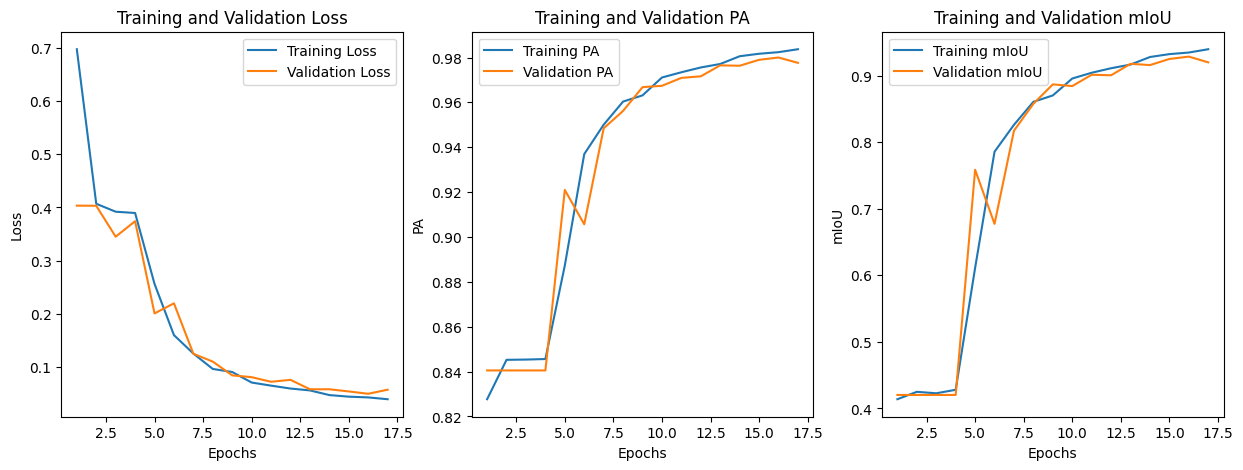

In [13]:
# Plot the training and validation metrics
epochs_range = range(1, len(training_results['tr_loss']) + 1)

#training_loss = [np.array(tensor).cpu().numpy() for tensor in training_results['tr_loss']]
#validation_loss = [np.array(tensor).cpu().numpy() for tensor in training_results['val_loss']]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, training_results['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, training_results['tr_pa'], label='Training PA')
plt.plot(epochs_range, training_results['val_pa'], label='Validation PA')
plt.xlabel('Epochs')
plt.ylabel('PA')
plt.legend()
plt.title('Training and Validation PA')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, training_results['tr_iou'], label='Training mIoU')
plt.plot(epochs_range, training_results['val_iou'], label='Validation mIoU')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()
plt.title('Training and Validation mIoU')


plt.show()

# Inference 

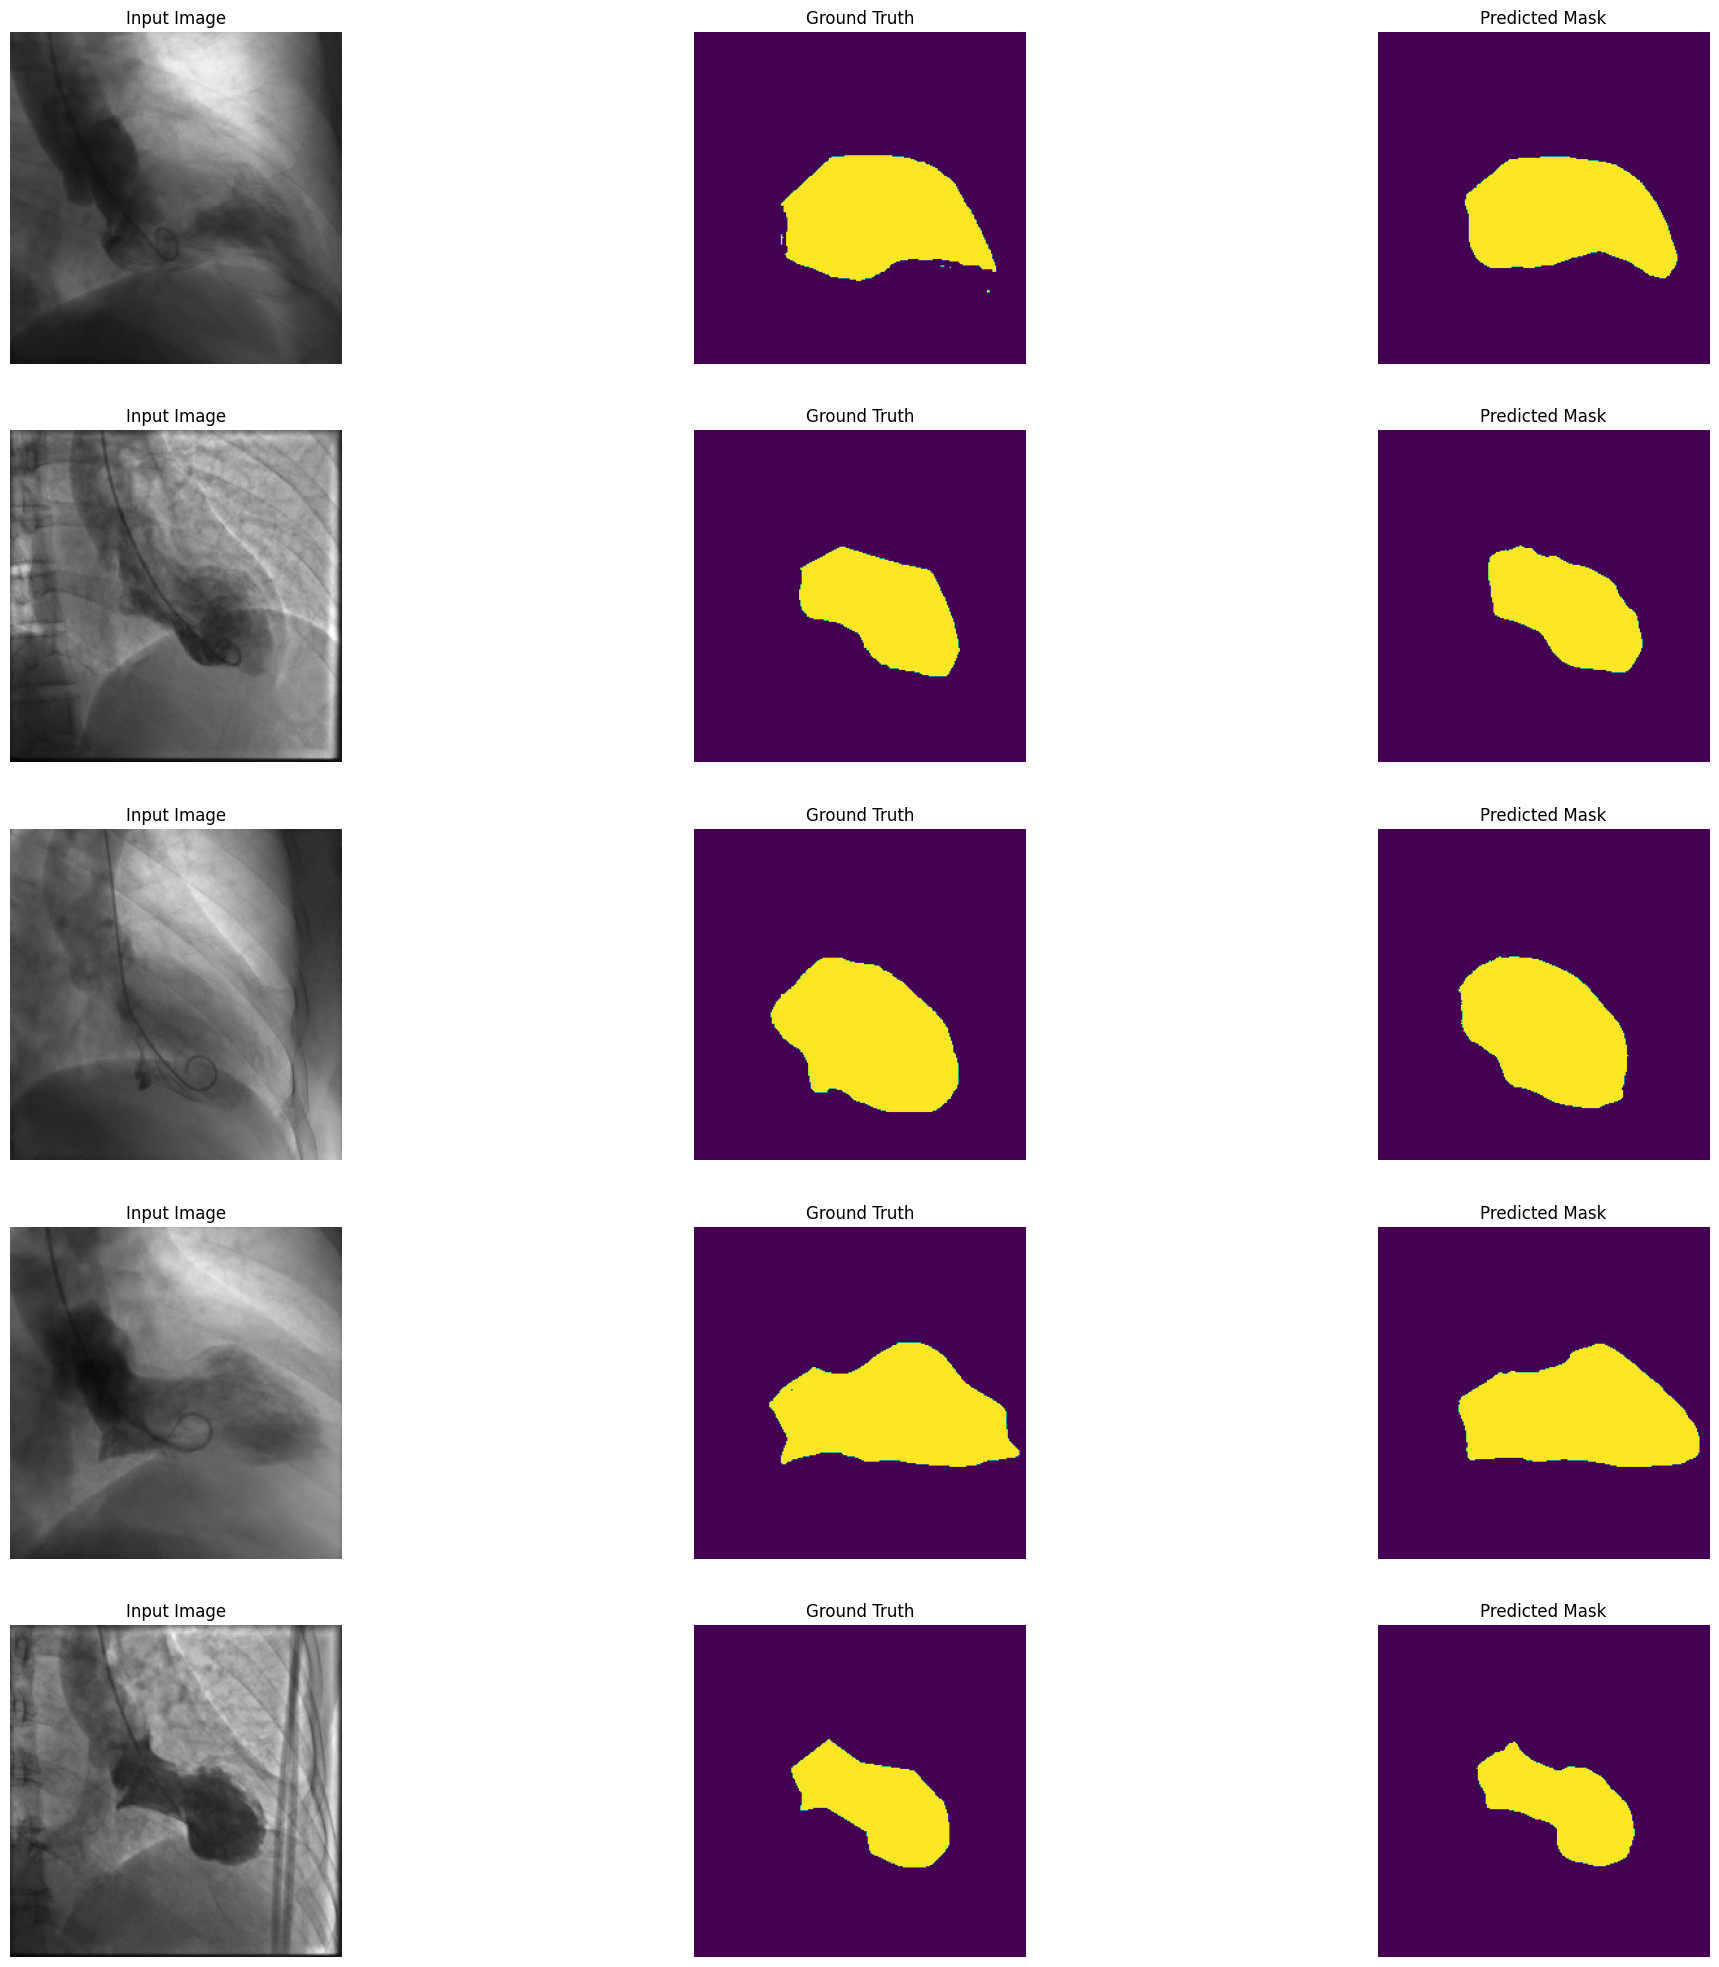

In [51]:
def inference(dl, model, device, n_ims=15):
    cols = 3
    rows = (n_ims + cols - 1) // cols 

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data
        # Get predicted mask
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
        ims.append(im.cpu().numpy())
        gts.append(gt.cpu().numpy())
        preds.append(pred.cpu().numpy())

    plt.figure(figsize=(25, 25))
    while count <= n_ims:  
        for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
            
            if count > n_ims:
                break
            plt.subplot(rows, cols, count)
            plt.imshow(im[0].transpose(1, 2, 0))
            plt.title("Input Image")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(gt[0])
            plt.title("Ground Truth")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(pred[0])
            plt.title("Predicted Mask")
            plt.axis('off')
            count += 1

    plt.show()

# Assuming ts_dl is from test dataloader
model = torch.load("/kaggle/working/_best_model.pth")
inference(test_dl, model=model, device=device)